In this notebook we apply the LambdaMART learning to rank method on a text search data set, using the XGBoost implementation of the algorithm. 

In [20]:
import numpy as np
import pickle
import xgboost as xgb
import graphviz


Loading in the data. The dat is of the form "reference lable (ie ranking given by human), query id, query-url pairs (length 136 feature vec)".

In [2]:
training_data = xgb.DMatrix('../LearningToRank/MSLR-WEB10K/Fold1/train_dat.txt')

[10:57:30] 723412x137 matrix with 98384032 entries loaded from ../LearningToRank/MSLR-WEB10K/Fold1/train_dat.txt
[10:57:30] 6000 groups are loaded from ../LearningToRank/MSLR-WEB10K/Fold1/train_dat.txt.group


Now want to set parameters to implement XGBoost

In [3]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'rank:pairwise'}
num_round = 10

In [4]:

bst = xgb.train(param, training_data, num_round)


In [6]:
bst

want to load in the testing data 

In [7]:
testing_data = xgb.DMatrix('../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt')

[10:58:15] 241521x137 matrix with 32846856 entries loaded from ../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt
[10:58:15] 0 groups are loaded from ../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt.group


In [8]:
preds = bst.predict(testing_data)

In [9]:
preds

array([ 0.6950459 ,  0.24924228,  0.36773652, ...,  0.89219534,
        0.04901469, -0.20689356], dtype=float32)

In [10]:
labels = testing_data.get_label()
print('error=%f' % (sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i]) / float(len(preds))))


error=0.466825


In [11]:
preds.max()

2.5227983

In [13]:
%matplotlib inline

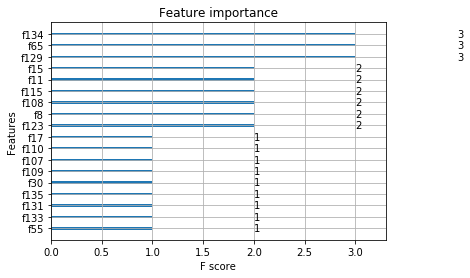

In [14]:
xgb.plot_importance(bst)

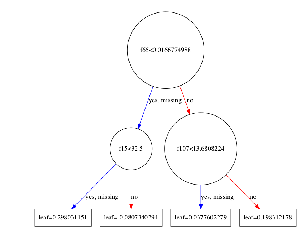

In [22]:
xgb.plot_tree(bst, num_trees=4)